# Pre-processing tuning

This notebook is used to tune the pre-processing of the data for the IOH prediction. The following steps signals are considered:
- Arterial pressure
- Heart rate
- Oxygen saturation
- Respiratory rate
- End tidal CO2
- Propofol target
- MAC value for volatile gaz 

In [37]:
from vitaldb import VitalFile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Download all the data for a single case

In [38]:
caseid = 2432
SOLAR_DEVICE_NAME = "Solar8000"
SOLAR_SIGNAL_NAMES = [
    "ART_MBP",
    "ART_SBP",
    "ART_DBP",
    "HR",
    "VENT_RR",
    "PLETH_SPO2",
    "ETCO2",
]
ORCHESTRA_DEVICE_NAME = "Orchestra"
ORCHESTRA_SIGNAL_NAMES = ["PPF20_CT"]
PRIMUS_DEVICE_NAME = "Primus"
PRIMUS_SIGNAL_NAMES = ["MAC"]
signal_names = (
        [f"{SOLAR_DEVICE_NAME}/" + f for f in SOLAR_SIGNAL_NAMES]
        + [f"{ORCHESTRA_DEVICE_NAME}/" + f for f in ORCHESTRA_SIGNAL_NAMES]
        + [f"{PRIMUS_DEVICE_NAME}/" + f for f in PRIMUS_SIGNAL_NAMES]
    )
SAMPLING_TIME = 1
case_data = VitalFile(caseid, signal_names).to_pandas(signal_names, SAMPLING_TIME)
case_data.rename(columns={'Solar8000/ART_MBP': 'mbp',
                            'Solar8000/ART_SBP': 'sbp',
                            'Solar8000/ART_DBP': 'dbp',
                            'Solar8000/HR': 'hr',
                            'Solar8000/VENT_RR': 'rr',
                            'Solar8000/PLETH_SPO2': 'spo2',
                            'Solar8000/ETCO2': 'etco2',
                            'Orchestra/PPF20_CT': 'pp_ct',
                            'Primus/MAC': 'mac'}, inplace=True)

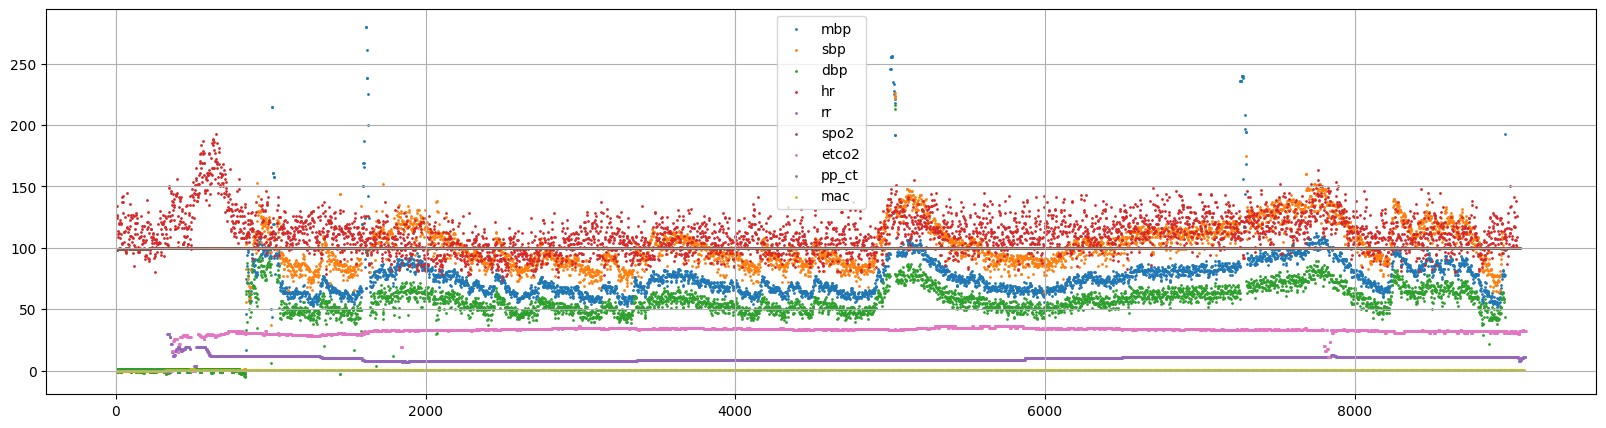

In [39]:
# print all the signals
plt.figure(figsize=(20,5))
for signal in case_data.columns:
    plt.scatter(case_data.index,case_data[signal], label=signal,s=1)
plt.legend()
plt.grid()
plt.show()


In [40]:
# remove data before the start of arterial pressure monitoring

case_data.mbp.mask(case_data.mbp < 40, inplace=True)
case_valid_mask = ~case_data.mbp.isna()
df_case = case_data[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]
df_case = df_case.reset_index(drop=True)


<Axes: >

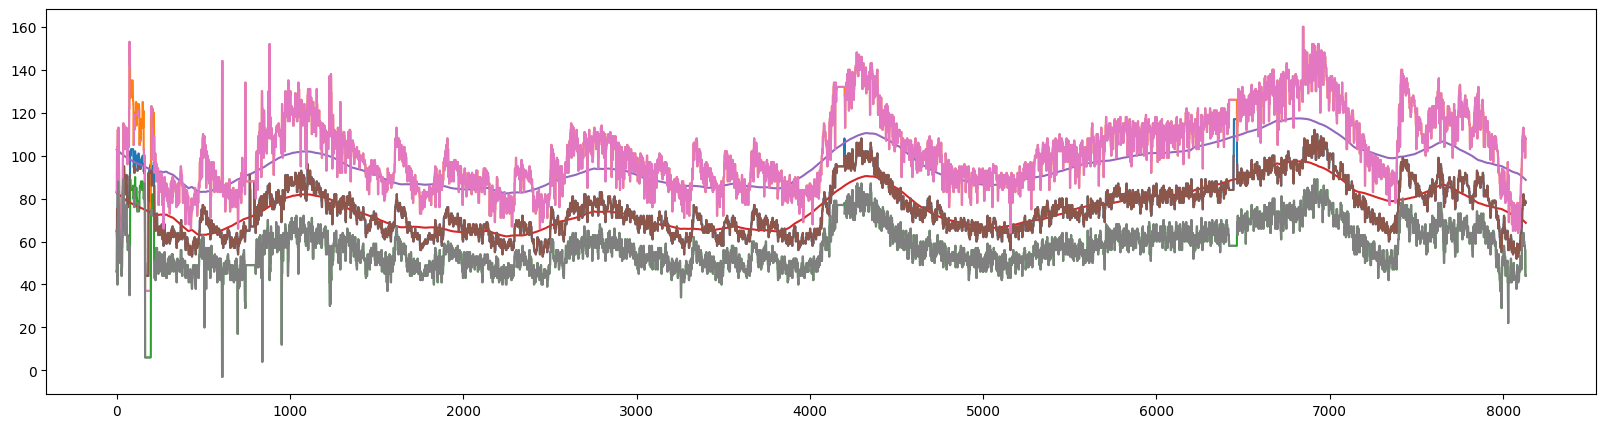

In [42]:

#fill the missing values with the previous value
df_case.ffill(inplace=True)

# remove the peaks on arterial pressure signals
window_size_value = 500
threshold_value = 20

plt.figure(figsize=(20,5))
df_case.mbp.plot()
df_case.sbp.plot()
df_case.dbp.plot()
rolling_mean = df_case.mbp.rolling(window=window_size_value, center=True, min_periods=10).mean()
# rolling_std = df.mbps.rolling(window=window_size_value, center=True).std()

rolling_mean.plot()
(rolling_mean + threshold_value).plot()

# Identify peaks based on the difference from the rolling mean
peaks = df_case[df_case.mbp > (rolling_mean + threshold_value )]
df_case.loc[peaks.index, ['mbp','sbp','dbp']] = np.nan
df_case.mbp.plot()
df_case.sbp.plot()
df_case.dbp.plot()



<Axes: >

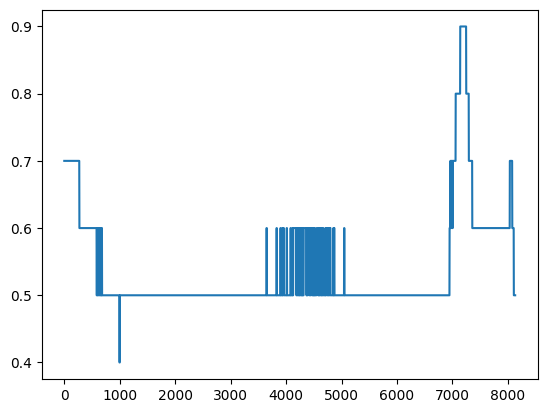

In [47]:
df_case.ffill(inplace=True)
df_case.mac.plot()